In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import BehaviourFeatureExtractor, plot_mouse_angle_to_pup, convert_seconds_to_frame
from VocalFeatureExtractor import VocalFeatureExtractor

## Reading Avisoft file - initial exploration ##

In [3]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file = "config.json")

Found items ['.DS_Store', 'MBI5335RR'] at directory data
Found items ['.DS_Store', 'MBI5335RR_240309_d6', 'MBI5335RR_240305_d2', 'MBI5335RR_240304_d1', 'MBI5335RR_240308_d5', 'MBI5335RR_240306_d3', 'MBI5335RR_240307_d4'] at directory data/MBI5335RR
Found items ['MBI5335RR_240309_d6_Avisoft', 'MBI5335RR_240309_d6_Behavior'] at directory data/MBI5335RR/MBI5335RR_240309_d6
Found items ['MBI5335RR_240309_d6_Avisoft_concatenated 2024-04-21  2_08 PM_Stats_SYNCCORRECTED.xlsx'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Avisoft
Found items ['MBI5335RR_d6DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.csv', 'MBI5335RR_240309_d6_BehavSummary.csv'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Behavior
Found items ['MBI5335RR_240305_d2_Behavior', 'MBI5335RR_240305_d2_Avisoft'] at directory data/MBI5335RR/MBI5335RR_240305_d2
Found items ['MBI5335RR_240305_d2_BehavSummary.csv', 'MBI5335RR_d2DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.

##### Day 1 trials #####

In [5]:
# get data for d1 experiment
day1_data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = "d1")

# fill out dataframes
df_summary = day1_data['Behavior']['df_summary']
df_DLC = day1_data['Behavior']['df_dlc']
df_Avi = day1_data['Avisoft']['df']

In [12]:
print(df_Avi.columns)
print("All vocalizations:", len(df_Avi))

Index(['File', 'ID', 'Label', 'Accepted', 'Score', 'BeginTime_s_',
       'EndTime_s_', 'CallLength_s_', 'PrincipalFrequency_kHz_',
       'LowFreq_kHz_', 'HighFreq_kHz_', 'DeltaFreq_kHz_',
       'FrequencyStandardDeviation_kHz_', 'Slope_kHz_s_', 'Sinuosity',
       'MeanPower_dB_Hz_', 'Tonality', 'PeakFreq_kHz_'],
      dtype='object')
All vocalizations: 290


In [13]:
df_Avi_USV = df_Avi[df_Avi['Accepted'] == True]

print("Accepted vocalizations:", len(df_Avi_USV))

Accepted vocalizations: 230


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


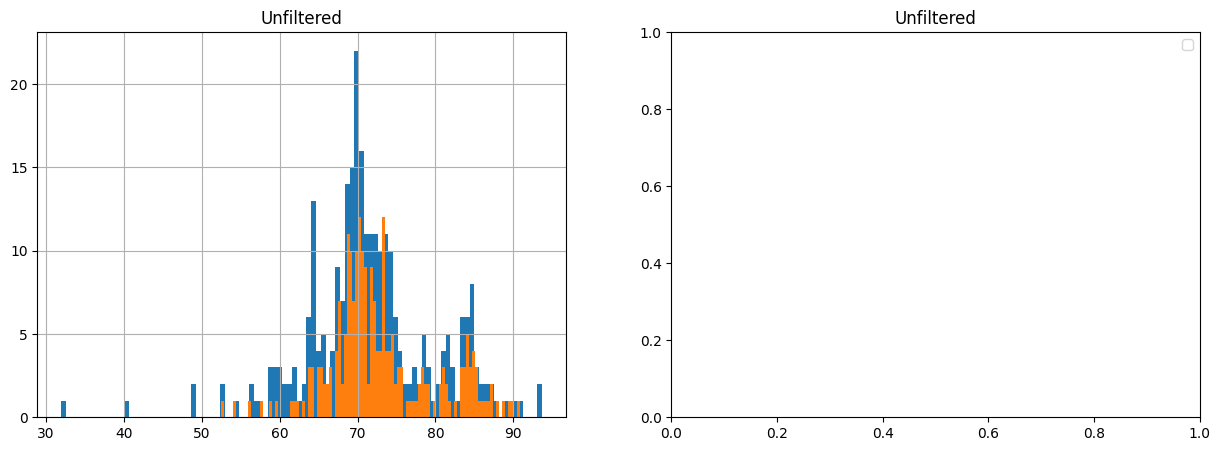

In [23]:
# histogram for squeak amplitudes
amplitude_col = "PrincipalFrequency_kHz_"

# create 2 figs
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

df_Avi[amplitude_col].hist(bins = 100, ax = ax[0], label = "All")
ax[0].set_title("Unfiltered")

df_Avi_USV[amplitude_col].hist(bins = 100, ax = ax[0], label = "Accepted")

plt.legend()